In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.linear_model import LinearRegression


In [2]:
# Investigate the file to understand data for cleaning
df = pd.read_excel('FCRDatasetPythonWork.xlsm')
print(df.head())


  Account Name  Interaction Id         Agent Name   Channel  Duration  \
0  Sirius_Corp        38834482       Amanda Moore      Call     159.0   
1  Sirius_Corp       704220696       Erica Parker      Call     208.0   
2  Sirius_Corp       182872588     Monica Bridges  Web Chat     585.0   
3  Sirius_Corp       527779592  Nicholas Trujillo      Call     378.0   
4  Sirius_Corp       616464956      Brian Solomon      Call    -991.0   

        Time of Interaction                  Inquiry Reason    Case ID  \
0  Jan 31 2025 07:07 PM EST  negative_balance/payment_plans  731178136   
1  Jan 31 2025 03:52 PM EST        account_settings/profile  567597826   
2  Jan 31 2025 08:09 AM EST            account_reactivation  331084573   
3  Jan 29 2025 06:12 PM EST         remainder_pay/_paycheck  998686495   
4  Jan 30 2025 08:06 PM EST            instant_transfer/rtp   37054764   

  Chat Delays Call Greeting Demonstrate Empathy Updated  \
0           -          True                        True  

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47958 entries, 0 to 47957
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Account Name                  47958 non-null  object 
 1   Interaction Id                47958 non-null  int64  
 2   Agent Name                    47958 non-null  object 
 3   Channel                       47958 non-null  object 
 4   Duration                      47067 non-null  float64
 5   Time of Interaction           47958 non-null  object 
 6   Inquiry Reason                46805 non-null  object 
 7   Case ID                       47958 non-null  int64  
 8   Chat Delays                   47958 non-null  object 
 9   Call Greeting                 47958 non-null  object 
 10  Demonstrate Empathy Updated   47958 non-null  object 
 11  Active Partnership DSAT       47958 non-null  bool   
 12  Dead Air - 20 Seconds         47958 non-null  object 
 13  N

In [4]:
# Starting to clean the data

# Fill missing values with appropriate defaults
df['Inquiry Reason'] = df['Inquiry Reason'].replace(['-', 'null', None], 'Unknown')



In [5]:
df['L1 Interaction Driver'] = df['L1 Interaction Driver'].fillna('Other')



In [6]:
df['L2 Interaction Driver'] = df['L2 Interaction Driver'].fillna('Other')

In [7]:
def clean_timezone(date_str):
    if isinstance(date_str, str):
        return re.sub(r'\s+\b[A-Z]{2,4}\b$', '', date_str) 
    return date_str  

# Apply function to clean time zone labels
df['Time of Interaction'] = df['Time of Interaction'].apply(clean_timezone)

# Ensure 'Time of Interaction' is in datetime format
df['Time of Interaction'] = pd.to_datetime(
    df['Time of Interaction'], 
    format="%b %d %Y %I:%M %p",  
    errors='coerce'
)

# Localize the naive datetime to 'America/New_York' (EST)
df['Time of Interaction'] = df['Time of Interaction'].dt.tz_localize('America/New_York', ambiguous='NaT', nonexistent='NaT')
df['Time of Interaction'] = df['Time of Interaction'].dt.tz_convert('UTC')

print(df[['Time of Interaction']].head())


        Time of Interaction
0 2025-02-01 00:07:00+00:00
1 2025-01-31 20:52:00+00:00
2 2025-01-31 13:09:00+00:00
3 2025-01-29 23:12:00+00:00
4 2025-01-31 01:06:00+00:00


In [8]:
df.columns = df.columns.str.strip()

In [9]:
# Understanding and cleaning the 'Duration' column
print(df['Duration'].describe())

count     47067.000000
mean      15704.470160
std       51753.398972
min       -1025.000000
25%         226.000000
50%         449.000000
75%        1018.000000
max      496337.000000
Name: Duration, dtype: float64


In [10]:
upper_bound = df['Duration'].quantile(0.90)  
print(f"99th Percentile Threshold: {upper_bound}")

99th Percentile Threshold: 36654.4


In [11]:
mean = df['Duration'].mean()
std_dev = df['Duration'].std()

lower_bound = mean - 3 * std_dev
upper_bound = mean + 3 * std_dev

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

Lower Bound: -139555.72675624938, Upper Bound: 170964.66707536892


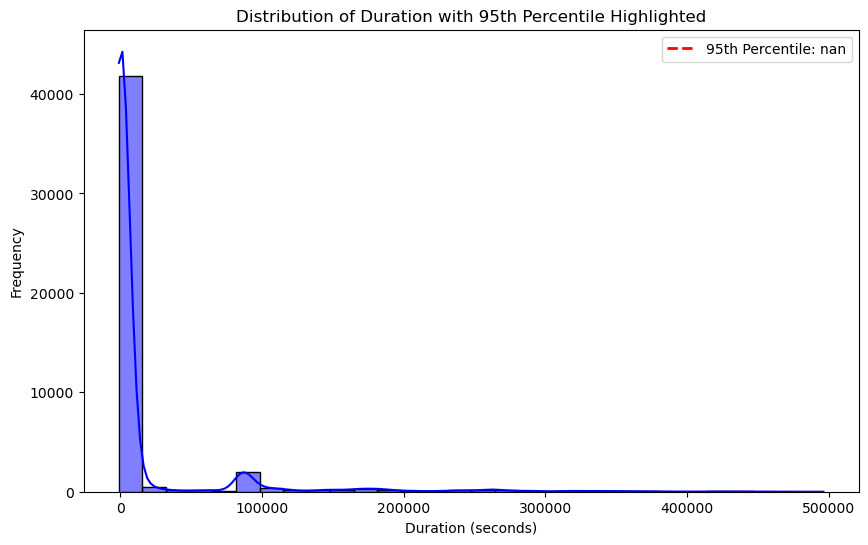

In [12]:
import numpy as np

# Calculate the 95th percentile threshold
percentile_95 = np.percentile(df['Duration'], 95)

plt.figure(figsize=(10, 6))
sns.histplot(df['Duration'], bins=30, kde=True, color='blue')

plt.axvline(percentile_95, color='red', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95:.2f}')

# Calculate sum of durations within the 95th percentile
sum_total_duration = df['Duration'].sum()
sum_95th_percentile = df[df['Duration'] <= percentile_95]['Duration'].sum()
concentration_ratio = sum_95th_percentile / sum_total_duration * 100

plt.text(percentile_95, plt.ylim()[1] * 0.9,
         f"{concentration_ratio:.2f}% of total\nDuration within 95th percentile",
         color='red', fontsize=12)

# Labels and title
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Duration with 95th Percentile Highlighted')
plt.legend()

# Show the plot
plt.show()


In [13]:
df = df[df['Duration'] >= 0]
print(df['Duration'].describe())

count     44987.00000
mean      16454.61660
std       52815.88058
min           0.00000
25%         251.00000
50%         477.00000
75%        1081.00000
max      496337.00000
Name: Duration, dtype: float64


In [14]:
# Calculate FCR by looking at the amount of 'Interaction ID' per 'Case ID':
number_of_calls = df.groupby('Case ID')['Interaction Id'].count()
print(number_of_calls.head())

repeat_calls = number_of_calls[number_of_calls > 1]  # Only cases with >1 interaction
print(repeat_calls.head())

# Compute FCR rate
total_cases = df['Case ID'].nunique()
FCR_cases = total_cases - repeat_calls.shape[0]  # Cases with only 1 interaction

FCR_rate = (FCR_cases / total_cases) * 100
print(f"FCR Rate: {FCR_rate:.2f}%")


Case ID
12224    1
57588    1
63042    1
76698    1
98410    1
Name: Interaction Id, dtype: int64
Case ID
315168     2
1266374    2
1309142    2
2368659    2
2503433    2
Name: Interaction Id, dtype: int64
FCR Rate: 91.07%


In [15]:
#Number of communications (Interaction IDs) per Case ID
number_of_calls = df.groupby('Case ID')['Interaction Id'].count().rename("Number of Calls")

df = df.merge(number_of_calls, on="Case ID", how="left")

print(df[['Case ID', 'Interaction Id', 'Number of Calls']].head())
print(df.columns)
print(df.head())


     Case ID  Interaction Id  Number of Calls
0  731178136        38834482                1
1  567597826       704220696                1
2  331084573       182872588                1
3  998686495       527779592                1
4  183668867       610603809                1
Index(['Account Name', 'Interaction Id', 'Agent Name', 'Channel', 'Duration',
       'Time of Interaction', 'Inquiry Reason', 'Case ID', 'Chat Delays',
       'Call Greeting', 'Demonstrate Empathy Updated',
       'Active Partnership DSAT', 'Dead Air - 20 Seconds',
       'Negative Agent Sentiment', 'Negative Customer Sentiment',
       'Positive Agent Sentiments', 'Positive Customer Sentiments', 'CSAT',
       'L1 Interaction Driver', 'L2 Interaction Driver', 'Number of Calls'],
      dtype='object')
  Account Name  Interaction Id         Agent Name   Channel  Duration  \
0  Sirius_Corp        38834482       Amanda Moore      Call     159.0   
1  Sirius_Corp       704220696       Erica Parker      Call     208.0  

In [16]:
print(df['Number of Calls'].describe())
print(df['Number of Calls'].value_counts())

count    44987.000000
mean         1.163914
std          0.370202
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Number of Calls, dtype: float64
Number of Calls
1    37613
2     7374
Name: count, dtype: int64


In [17]:
df.columns

Index(['Account Name', 'Interaction Id', 'Agent Name', 'Channel', 'Duration',
       'Time of Interaction', 'Inquiry Reason', 'Case ID', 'Chat Delays',
       'Call Greeting', 'Demonstrate Empathy Updated',
       'Active Partnership DSAT', 'Dead Air - 20 Seconds',
       'Negative Agent Sentiment', 'Negative Customer Sentiment',
       'Positive Agent Sentiments', 'Positive Customer Sentiments', 'CSAT',
       'L1 Interaction Driver', 'L2 Interaction Driver', 'Number of Calls'],
      dtype='object')

In [18]:
# Calculate repeat communications per channel
df.columns = df.columns.str.strip()

repeat_calls = df[df.duplicated(subset=['Case ID'], keep=False)]

if 'Channel' in repeat_calls.columns:
    total_cases_by_channel = df.groupby('Channel')['Case ID'].nunique()
    repeat_cases_by_channel = repeat_calls.groupby('Channel')['Case ID'].nunique()

    repeat_case_proportion = (repeat_cases_by_channel / repeat_cases_by_channel.sum()) * 100
repeat_case_proportion.to_frame()




,Case ID
Channel,
Call,50.006782
Email,49.993218


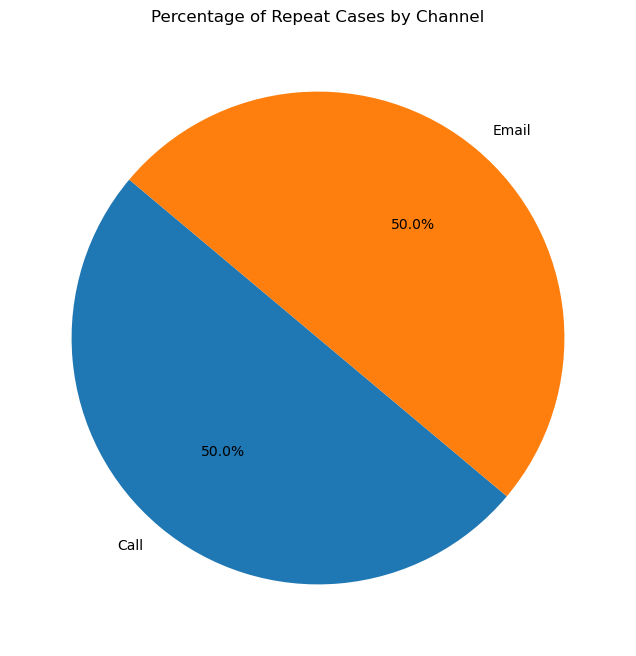

In [19]:
import matplotlib.pyplot as plt

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(repeat_case_proportion, labels=repeat_case_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Repeat Cases by Channel")
plt.show()


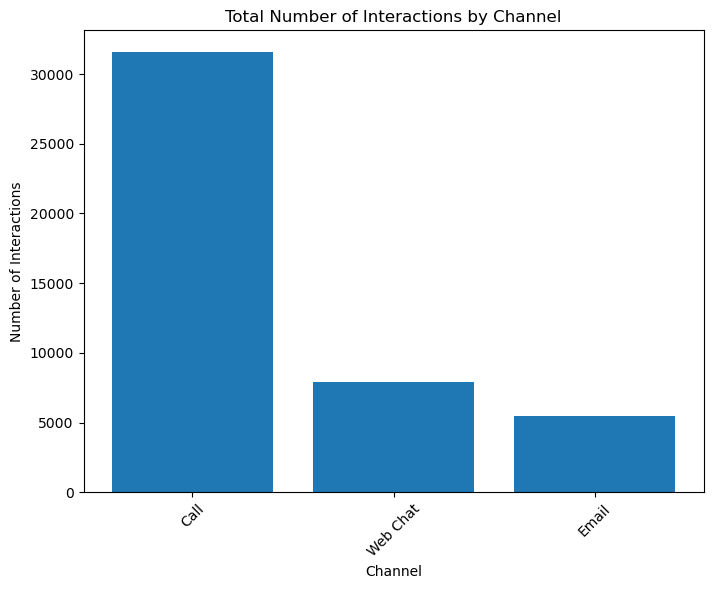

In [20]:
# Count the total number of interactions for each channel
total_interactions_by_channel = df['Channel'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(total_interactions_by_channel.index, total_interactions_by_channel.values)
plt.xlabel("Channel")
plt.ylabel("Number of Interactions")
plt.title("Total Number of Interactions by Channel")
plt.xticks(rotation=45)
plt.show()


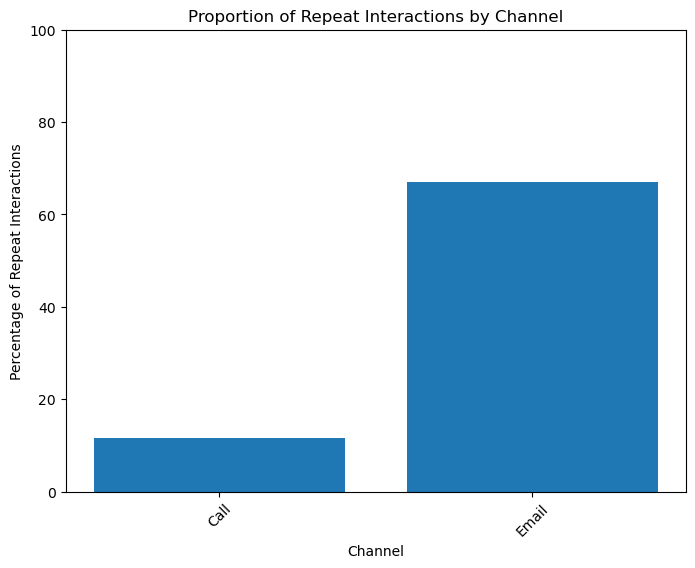

In [21]:
# Calculate the proportion of repeat interactions relative to total interactions for each channel
repeat_interaction_proportion = (repeat_calls['Channel'].value_counts() / df['Channel'].value_counts()) * 100

# Plot bar chart
plt.figure(figsize=(8, 6))
plt.bar(repeat_interaction_proportion.index, repeat_interaction_proportion.values)
plt.xlabel("Channel")
plt.ylabel("Percentage of Repeat Interactions")
plt.title("Proportion of Repeat Interactions by Channel")
plt.xticks(rotation=45)
plt.ylim(0, 100)  # Set y-axis limit for better visualization
plt.show()


In [22]:
# Analyze the factors influencing first interaction resolution rate

single_interaction_cases = df['Case ID'].value_counts()[df['Case ID'].value_counts() == 1].index
single_interaction_df = df[df['Case ID'].isin(single_interaction_cases)]

repeat_interaction_cases = df['Case ID'].value_counts()[df['Case ID'].value_counts() > 1].index
repeat_interaction_df = df[df['Case ID'].isin(repeat_interaction_cases)]

first_resolution_rate_by_channel = single_interaction_df['Channel'].value_counts() / df['Channel'].value_counts() * 100

first_resolution_rate_by_inquiry = single_interaction_df['Inquiry Reason'].value_counts() / df['Inquiry Reason'].value_counts() * 100

first_resolution_rate_by_agent = single_interaction_df['Agent Name'].value_counts() / df['Agent Name'].value_counts() * 100

first_resolution_rate_by_channel_df = first_resolution_rate_by_channel.to_frame(name="First Interaction Resolution Rate (%)")
first_resolution_rate_by_inquiry_df = first_resolution_rate_by_inquiry.to_frame(name="First Interaction Resolution Rate (%)")
first_resolution_rate_by_agent_df = first_resolution_rate_by_agent.to_frame(name="First Interaction Resolution Rate (%)")

first_resolution_rate_by_channel_df, first_resolution_rate_by_inquiry_df, first_resolution_rate_by_agent_df

(          First Interaction Resolution Rate (%)
 Channel                                        
 Call                                  88.316173
 Web Chat                             100.000000
 Email                                 33.018354,
                                 First Interaction Resolution Rate (%)
 Inquiry Reason                                                       
 Unknown                                                     97.082954
 account_activation                                          80.835655
 account_balance                                             92.989289
 account_cancellation                                        89.254386
 account_reactivation                                        58.277169
 account_settings/profile                                    68.265961
 ach/next_day_transfer                                       97.198538
 card_support                                                97.096457
 earnings_delay                             

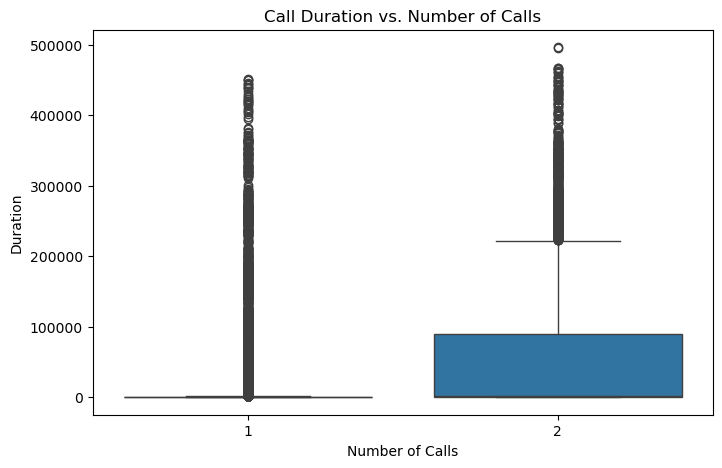

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['Number of Calls'], y=df['Duration'])
plt.title("Call Duration vs. Number of Calls")
plt.show()

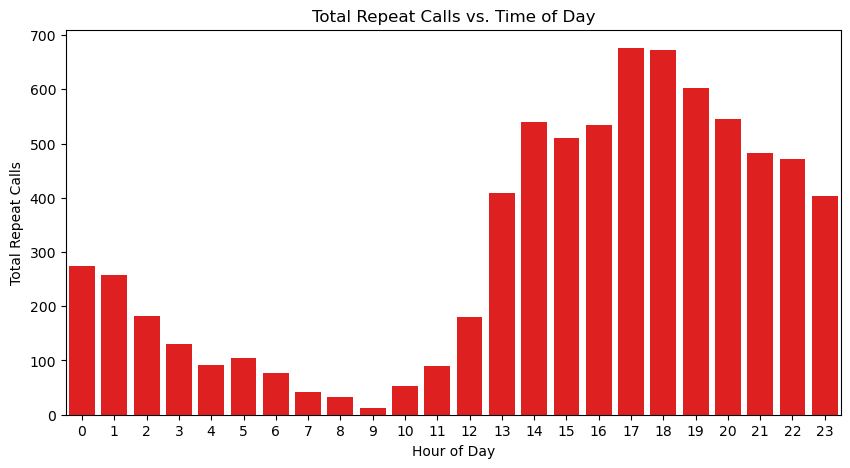

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'Hour' not in df.columns:
    df['Hour'] = pd.to_datetime(df['Time of Interaction']).dt.hour

# Identify repeat calls (assuming repeat calls have duplicate 'Case ID')
repeat_calls = df[df.duplicated(subset=['Case ID'], keep=False)]

repeat_calls_by_hour = repeat_calls.groupby('Hour').size()

plt.figure(figsize=(10, 5))
sns.barplot(x=repeat_calls_by_hour.index, y=repeat_calls_by_hour.values, color='red')

plt.title("Total Repeat Calls vs. Time of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Total Repeat Calls")

plt.show()




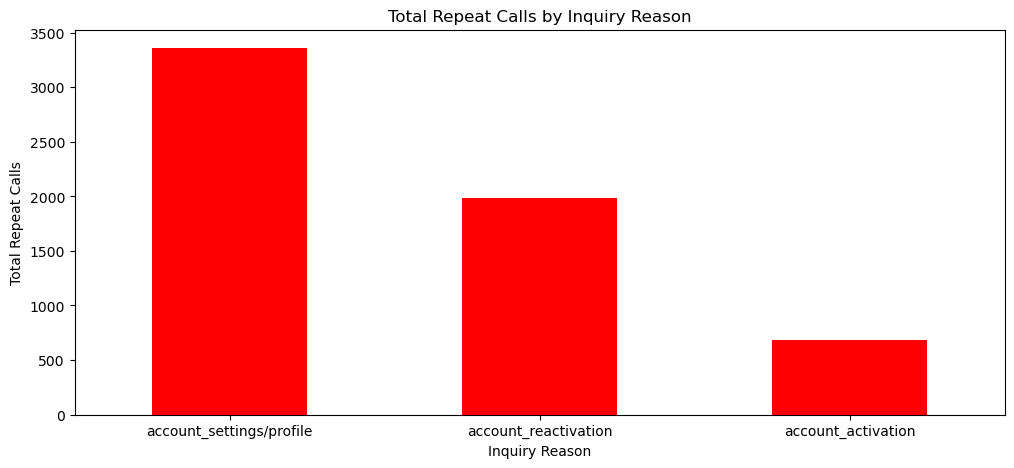

In [25]:
# Identify repeat calls inquiry reason
repeat_calls = df[df.duplicated(subset=['Case ID'], keep=False)]

repeat_calls_by_inquiry = repeat_calls.groupby('Inquiry Reason').size().sort_values(ascending=False)

plt.figure(figsize=(12, 5))
repeat_calls_by_inquiry[:3].plot(kind='bar', color='red')  # Show top 15 issues

plt.title("Total Repeat Calls by Inquiry Reason")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=0)

plt.show()



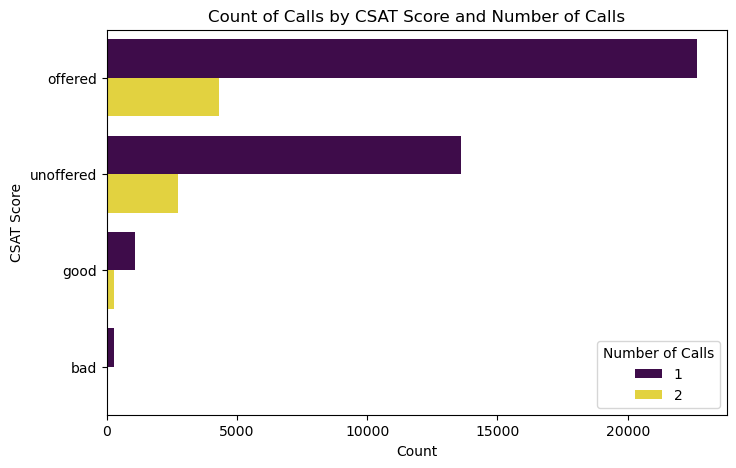

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(y=df['CSAT'], hue=df['Number of Calls'], palette="viridis")

plt.title("Count of Calls by CSAT Score and Number of Calls")
plt.xlabel("Count")
plt.ylabel("CSAT Score")

plt.show()


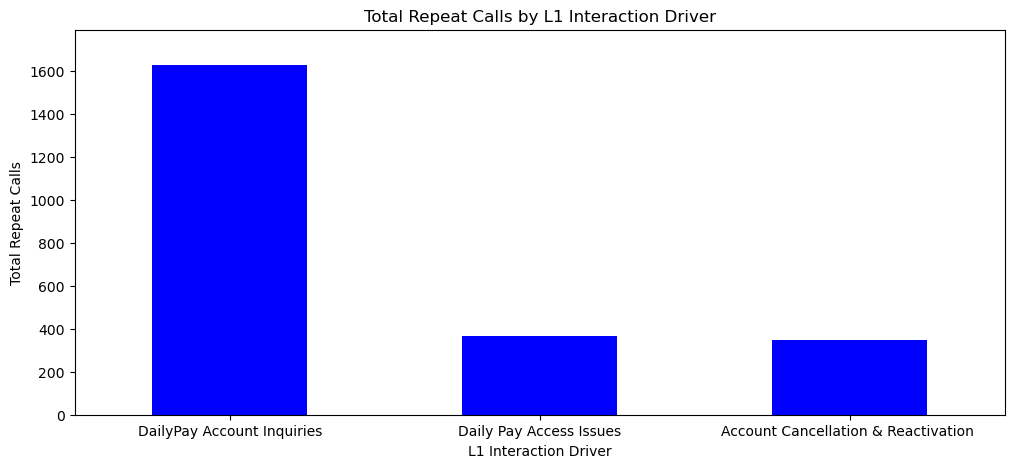

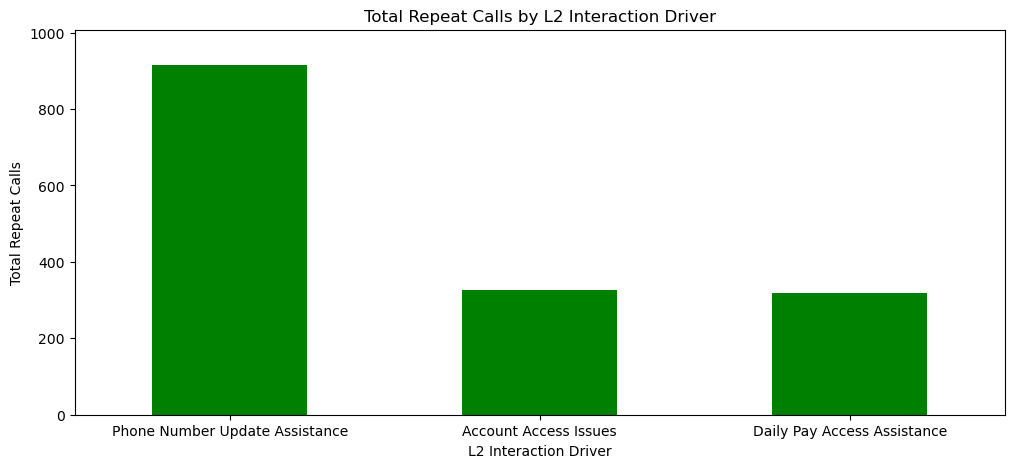

In [27]:
# Identify repeat calls for L1 and L2 Drivers
repeat_calls = df[df.duplicated(subset=['Case ID'], keep=False)]

repeat_calls_by_L1 = repeat_calls.groupby('L1 Interaction Driver').size().sort_values(ascending=False)
repeat_calls_by_L2 = repeat_calls.groupby('L2 Interaction Driver').size().sort_values(ascending=False)

repeat_calls_by_L1 = repeat_calls_by_L1.loc[repeat_calls_by_L1.index != 'Other']
repeat_calls_by_L2 = repeat_calls_by_L2.loc[repeat_calls_by_L2.index != 'Other']

plt.figure(figsize=(12, 5))
repeat_calls_by_L1[:3].plot(kind='bar', color='blue')  # Show top 15 L1 issues
plt.title("Total Repeat Calls by L1 Interaction Driver")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=0)
plt.ylim(0, repeat_calls_by_L1.max() * 1.1)  # Set y-axis range dynamically
plt.show()

plt.figure(figsize=(12, 5))
repeat_calls_by_L2[:3].plot(kind='bar', color='green')  # Show top 15 L2 issues
plt.title("Total Repeat Calls by L2 Interaction Driver")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=0)
plt.ylim(0, repeat_calls_by_L2.max() * 1.1)  # Set y-axis range dynamically
plt.show()





In [28]:
# Make a correlation heatmap on variables and how they relate
df.columns = df.columns.str.strip()  

boolean_cols = [
    'Chat Delays', 'Call Greeting', 'Demonstrate Empathy Updated', 
    'Active Partnership DSAT', 'Dead Air - 20 Seconds',
    'Negative Agent Sentiment', 'Negative Customer Sentiment',
    'Positive Agent Sentiments', 'Positive Customer Sentiments'
]

# Convert 'TRUE'/'FALSE' to 1/0 and replace ' ' with NaN
for col in boolean_cols:
    df[col] = df[col].replace({'TRUE': 1, 'FALSE': 0, '-': None})  # Use NaN for missing

df['Number of Calls'] = pd.to_numeric(df['Number of Calls'], errors='coerce')



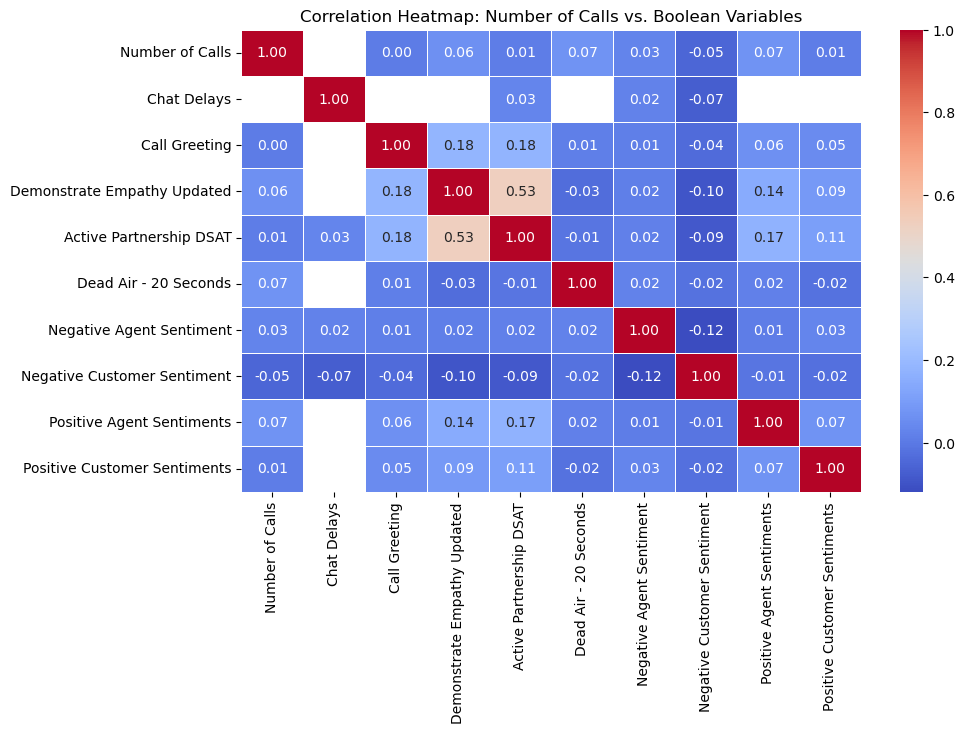

In [29]:
# Select only numeric columns for correlation analysis
correlation_df = df[['Number of Calls'] + boolean_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Number of Calls vs. Boolean Variables")
plt.show()


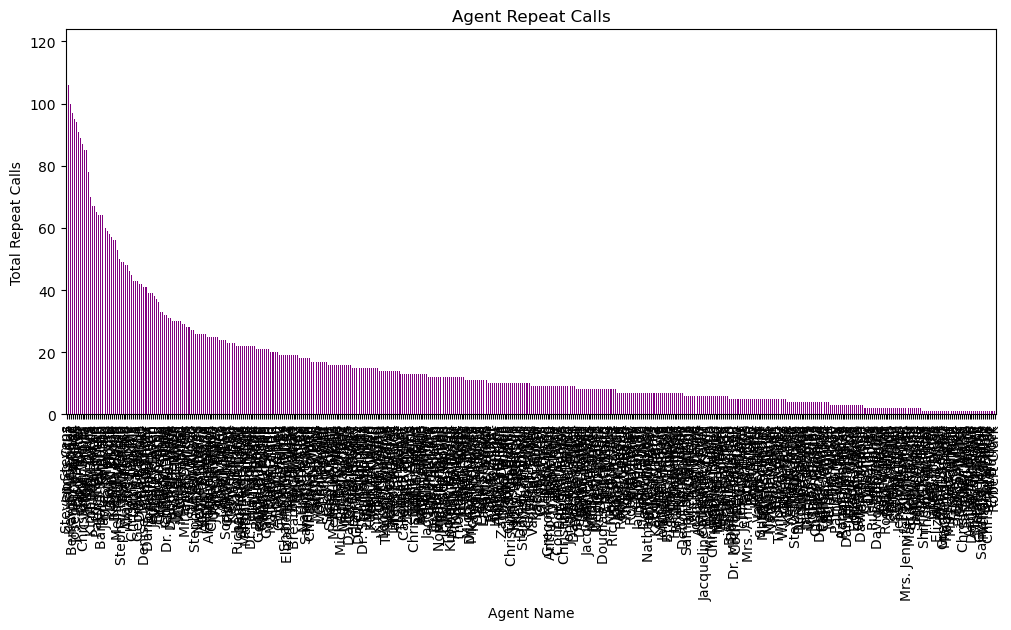

In [30]:
# Count the number of repeat calls per agent
repeat_calls_by_agent = repeat_calls['Agent Name'].value_counts()

plt.figure(figsize=(12, 5))
repeat_calls_by_agent.plot(kind='bar', color='purple')  # Show top 15 agents

plt.title("Agent Repeat Calls")
plt.xlabel("Agent Name")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=90)

plt.show()


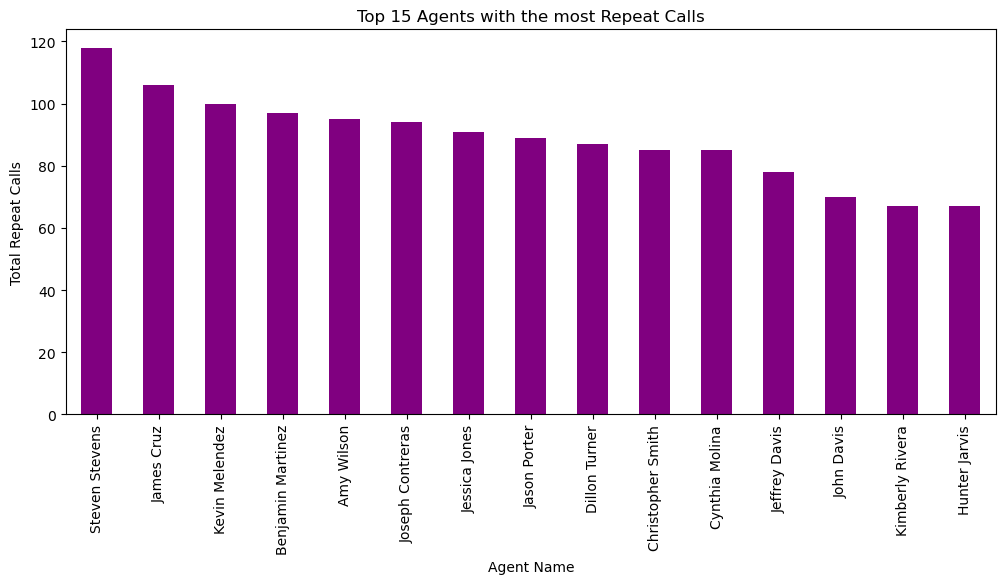

In [31]:
# Count the number of repeat calls per agent
repeat_calls_by_agent = repeat_calls['Agent Name'].value_counts()

plt.figure(figsize=(12, 5))
repeat_calls_by_agent[:15].plot(kind='bar', color='purple')  # Show top 15 agents

plt.title("Top 15 Agents with the most Repeat Calls")
plt.xlabel("Agent Name")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=90)

plt.show()

In [32]:
from scipy.stats import chisquare
#Testing the statistical significance of repeat calls and emails by agent


repeat_calls = repeat_calls[repeat_calls['Channel'] == 'Call']
repeat_emails = repeat_calls[repeat_calls['Channel'] == 'Email']


repeat_calls_per_agent = repeat_calls['Agent Name'].value_counts()
repeat_emails_per_agent = repeat_emails['Agent Name'].value_counts()


expected_calls_calls = [repeat_calls_per_agent.sum() / len(repeat_calls_per_agent)] * len(repeat_calls_per_agent)
expected_calls_emails = [repeat_emails_per_agent.sum() / len(repeat_emails_per_agent)] * len(repeat_emails_per_agent)


chi_stat_calls, p_value_calls = chisquare(repeat_calls_per_agent, expected_calls_calls)


chi_stat_emails, p_value_emails = chisquare(repeat_emails_per_agent, expected_calls_emails)


chi_squared_results = {
    "Call Channel": {"Chi-Square": chi_stat_calls, "p-value": p_value_calls},
    "Email Channel": {"Chi-Square": chi_stat_emails, "p-value": p_value_emails},
}

chi_squared_results


/var/folders/vq/1hwwxcps5q1cgdgbrh24mct80000gn/T/ipykernel_10600/1778042011.py:14: RuntimeWarning: invalid value encountered in scalar divide
  expected_calls_emails = [repeat_emails_per_agent.sum() / len(repeat_emails_per_agent)] * len(repeat_emails_per_agent)


{'Call Channel': {'Chi-Square': 1957.5390455531447,
  'p-value': 5.063001784262964e-193},
 'Email Channel': {'Chi-Square': 0.0, 'p-value': nan}}

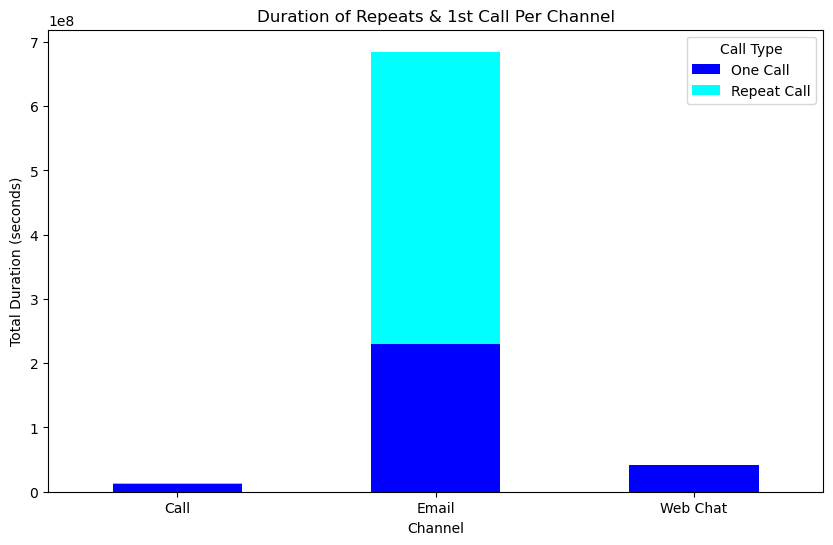

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Repeat and 1 time call Duration by Channel
df['Repeat Status'] = np.where(df['Number of Calls'] > 1, 'Repeat Call', 'One Call')

duration_by_channel = df.groupby(['Channel', 'Repeat Status'])['Duration'].sum().unstack()

ax = duration_by_channel.plot(kind='bar', stacked=True, figsize=(10, 6), color=['blue', 'cyan'])

plt.title("Duration of Repeats & 1st Call Per Channel")
plt.xlabel("Channel")
plt.ylabel("Total Duration (seconds)")
plt.legend(title="Call Type")
plt.xticks(rotation=0)

plt.show()


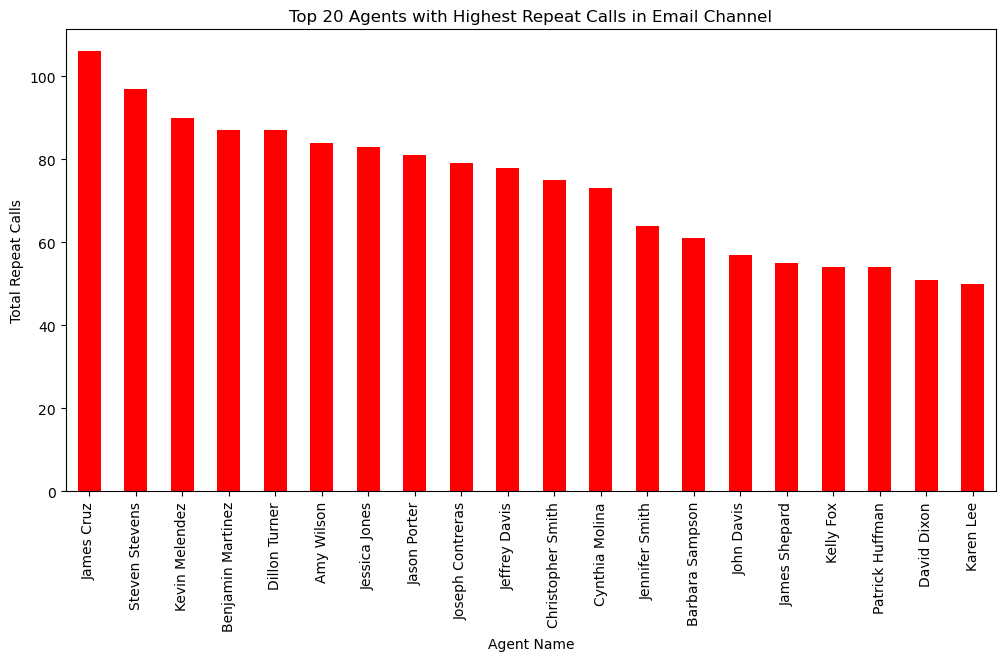

In [34]:
# Top 20 agents with highest repeat calls in Email channel
repeat_email_calls = df[(df['Number of Calls'] > 1) & (df['Channel'] == 'Email')]

repeat_email_calls_by_agent = repeat_email_calls['Agent Name'].value_counts().head(20)

plt.figure(figsize=(12, 6))
repeat_email_calls_by_agent.plot(kind='bar', color='red')

plt.title("Top 20 Agents with Highest Repeat Calls in Email Channel")
plt.xlabel("Agent Name")
plt.ylabel("Total Repeat Calls")
plt.xticks(rotation=90)

plt.show()


In [35]:
# Sort the dataset by 'Case ID' and 'Time of Interaction' to get the first interaction per case
df_sorted = df.sort_values(by=['Case ID', 'Time of Interaction'])

first_interaction = df_sorted.groupby('Case ID').first()

initial_channel_counts = first_interaction['Channel'].value_counts()

initial_channel_counts



Channel
Call        29418
Web Chat     7919
Email        3963
Name: count, dtype: int64

In [36]:
# Identify follow-up interactions by excluding the first interaction per case
follow_up_interactions = df_sorted[~df_sorted.index.isin(first_interaction.index)]

follow_up_email_count = (follow_up_interactions['Channel'] == 'Email').sum()

follow_up_channel_counts = follow_up_interactions['Channel'].value_counts()

follow_up_channel_counts

Channel
Call        31564
Web Chat     7919
Email        5503
Name: count, dtype: int64

/var/folders/vq/1hwwxcps5q1cgdgbrh24mct80000gn/T/ipykernel_10600/865499580.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_call_df[col] = filtered_call_df[col].replace({'True': 1, 'False': 0, '-': None}).astype(float)
/var/folders/vq/1hwwxcps5q1cgdgbrh24mct80000gn/T/ipykernel_10600/865499580.py:43: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  filtered_call_df[col] = filtered_call_df[col].replace({'True': 1, 'False': 0, '-': None}).astype(float)
/var/folders/vq/1hwwxcps5q1cgdgbrh24mct80000gn/T/ipykernel_1

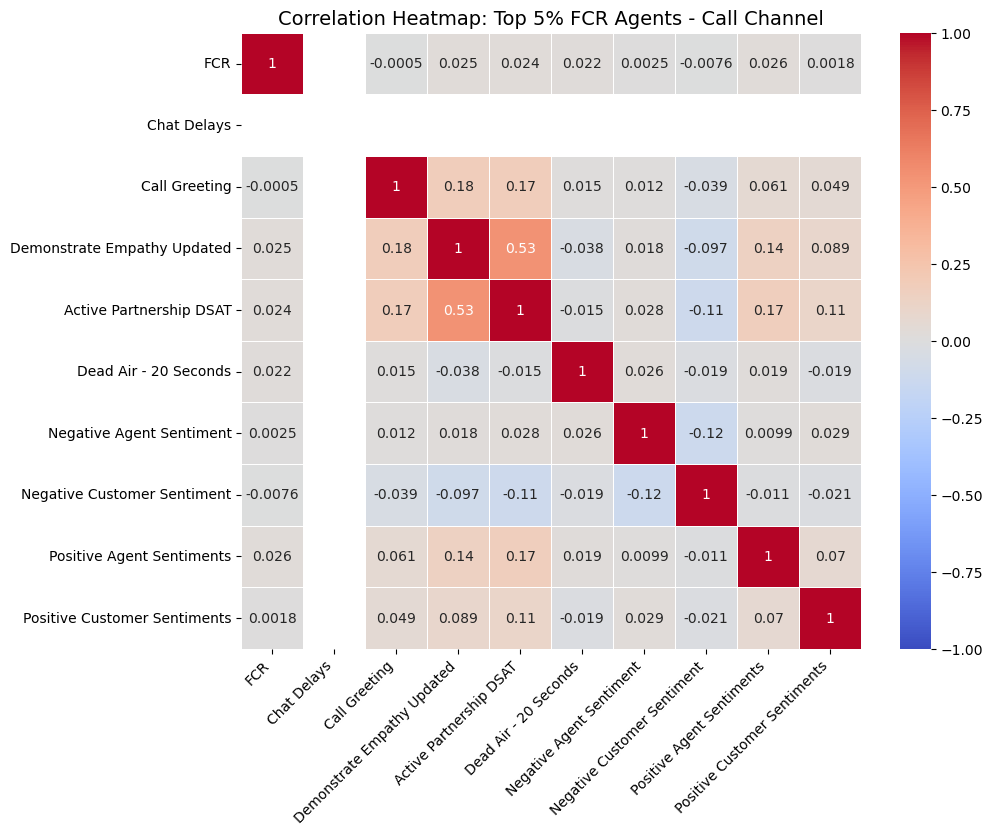

In [38]:
import pandas as pd

# Load the dataset
file_path = "FCRDataset.xlsm"  # Ensure this file is in the same directory
xls = pd.ExcelFile(file_path)

# Load the main dataset sheet
df = pd.read_excel(xls, sheet_name="Dataset")

# Step 1: Define FCR (First Call Resolution Rate)
# Count the number of interactions per Case ID
fcr_counts = df.groupby('Case ID')['Interaction Id'].count().reset_index()
fcr_counts.rename(columns={'Interaction Id': 'FCR'}, inplace=True)

# Merge FCR back to the original dataset
df = df.merge(fcr_counts, on='Case ID', how='left')

# Step 2: Filter for 'Call' channel only
call_agents = df[df['Channel'] == 'Call'].copy()

# Calculate the top 5% threshold for FCR
top_5_threshold_fcr = call_agents['FCR'].quantile(0.95)

# Identify agents with the top 5% FCR
top_5_fcr_agents = call_agents[call_agents['FCR'] >= top_5_threshold_fcr]['Agent Name'].unique()

# Apply filters: Only 'Call' channel and top 5% FCR agents
filtered_call_df = df[(df['Agent Name'].isin(top_5_fcr_agents)) & (df['Channel'] == 'Call')]

# Ensure column names are stripped of extra spaces
filtered_call_df.columns = filtered_call_df.columns.str.strip()

# Define correlation columns
correlation_columns = [
    'FCR', 'Chat Delays', 'Call Greeting', 'Demonstrate Empathy Updated', 
    'Active Partnership DSAT', 'Dead Air - 20 Seconds', 'Negative Agent Sentiment', 
    'Negative Customer Sentiment', 'Positive Agent Sentiments', 'Positive Customer Sentiments'
]

# Convert categorical values to numeric (True/False to 1/0, '-' to NaN)
for col in correlation_columns[1:]:  # Skip 'FCR' since it's already numeric
    if col in filtered_call_df.columns:
        filtered_call_df[col] = filtered_call_df[col].replace({'True': 1, 'False': 0, '-': None}).astype(float)

# Compute the correlation matrix
correlation_matrix_call_top5 = filtered_call_df[correlation_columns].corr()

# Generate a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))  # Set figure size
sns.heatmap(
    correlation_matrix_call_top5, 
    annot=True,  # Display correlation values
    cmap="coolwarm",  # Color scheme (blue to red)
    center=0,  # Center the colormap at 0
    linewidths=0.5,  # Grid lines
    vmin=-1, vmax=1  # Set min/max values
)

# Add title and adjust labels
plt.title("Correlation Heatmap: Top 5% FCR Agents - Call Channel", fontsize=14)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Show the plot
plt.show()



